In [4]:
import pandas as pd

df_pha = pd.read_csv('datasets/Psychosocial_Health_Analysis.csv')
df_pha['problem_category'] = df_pha['problem_category'].str.lower().str.strip()
df_pha['psychological_catehory'] = df_pha['psychological_catehory'].str.lower().str.strip()

df_pha = df_pha[
    (df_pha['problem_category'] == 'stress') | 
    (df_pha['problem_category'] == 'anxiety') |
    (df_pha['psychological_catehory'] == 'stress') |
    (df_pha['psychological_catehory'] == 'anxiety')
    ]

df_pha['label'] = 1
df_pha = df_pha.rename(columns={'Problem_description': 'text'})

df_pha = df_pha.drop(['Age', 'Gender', 'problem_summary', 'problem_category', 'psychological_catehory'], axis=1)

df_pha.head()

,text,label
0,A woman is sharing their challenges as the on...,1
3,"How to increase confidence? Feeling insecure, ...",1
5,"The user is in a complicated situation, caught...",1
6,The user was previously in a relationship but ...,1
8,The user is experiencing emotional turmoil due...,1


In [5]:
df_stress = pd.read_csv('datasets/Stress.csv')

df_stress = df_stress.drop(['subreddit','post_id','sentence_range','confidence','social_timestamp'], axis=1)

df_stress.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [6]:
df_mhc = pd.read_csv('datasets/NLP_Mental_Health_Conversations.csv')

df_mhc['label'] = 1
df_mhc = df_mhc.rename(columns={'Context': 'text'})

df_mhc = df_mhc.drop('Response', axis=1)
df_mhc = df_mhc.drop_duplicates()

df_mhc.head()

,text,label
0,I'm going through some things with my feelings...,1
23,I have so many issues to address. I have a his...,1
70,I have been feeling more and more down for ove...,1
72,I’m facing severe depression and anxiety and I...,1
81,How can I get to a place where I can be conten...,1


In [7]:
# Read in reddit posts from subreddits that are deemed positive. Note: Some datasets are too large, and are split into parts instead.
import re

filepaths = [
    ("datasets/reddit/MadeMeSmile_submissions00.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions01.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions02.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions03.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions04.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions05.zip", 90),
    ("datasets/reddit/wholesome_submissions.zip", 600)    
]

df_positive = pd.DataFrame(columns=['selftext'])

for f in filepaths:
    df_temp = pd.read_json(f[0], lines=True)[['selftext']]
    df_temp['selftext'] = df_temp['selftext'].apply(lambda x: re.sub(r'http\S+', '', x))
    df_temp = df_temp[
        (df_temp['selftext'] != '') & 
        (df_temp['selftext'] != '[deleted]') & 
        (df_temp['selftext'] != '[removed]') &
        (df_temp['selftext'].apply(lambda x: len(x.split()) >= 10))
    ].sample(f[1])

    df_positive = pd.concat([df_positive, df_temp], ignore_index=True)

df_positive = df_positive.reset_index(drop=True)

df_positive['label'] = 0
df_positive = df_positive.rename(columns={'selftext' : 'text'})

df_positive.head()

,text,label
0,Be happy. Days like this last so much longer t...,0
1,"Roughly every night at 12am, I get out of bed ...",0
2,The other day my dad posted a song he wrote ye...,0
3,Someone posted that they got Goose Bums listen...,0
4,"Probably a repost, but I haven't seen it in a ...",0


In [8]:
# Combine all datasets into a single dataframe
df = pd.concat([df_pha, df_stress, df_mhc, df_positive], ignore_index=True)
df = df.reset_index(drop=True)

df.head()

,text,label
0,A woman is sharing their challenges as the on...,1
1,"How to increase confidence? Feeling insecure, ...",1
2,"The user is in a complicated situation, caught...",1
3,The user was previously in a relationship but ...,1
4,The user is experiencing emotional turmoil due...,1


In [9]:
import nltk
import re
from urllib.parse import urlparse
from spacy import load
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [21]:
# Clean up and lemmatize the texts.

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    for word in tokens:
        if word in stop_words:
            tokens.remove(word)

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    return ' '.join(text)

df['processed_text'] = df['text'].apply(lambda x: process_texts(x))

df.sample(10)


,text,label,processed_text
4575,"I’m glad they are bonding, but this is hilario...",0,glad be bond hilarious me this be boomer dad m...
2794,Posting this here as I didn't know about this ...,0,post here know this sub direct originally post...
488,So lets forget all about my biological father....,0,let forget about biological father father tell...
3088,"I'm a teenager, and I struggle with going out ...",1,teenager struggle go and talk people feel awfu...
2522,Oh Jesus Christ. I blacked out in front of my ...,1,oh jesus christ black front family my family h...
4559,Hey guys. I recently created a subreddit calle...,0,hey guy recently create subreddit call dadcoun...
2510,"I live in BC and im gonna be homeless soon, I'...",0,live bc im gon na homeless soon think just sav...
4368,For years we went to the beach for our family ...,0,year go beach family vacation every year daugh...
2381,"University makes my anxiety really bad, I'm to...",1,university make anxiety really bad scar ever a...
3580,"Every once and a while, I think about my ex-bo...",1,every think ex boyfriend four year ago current...


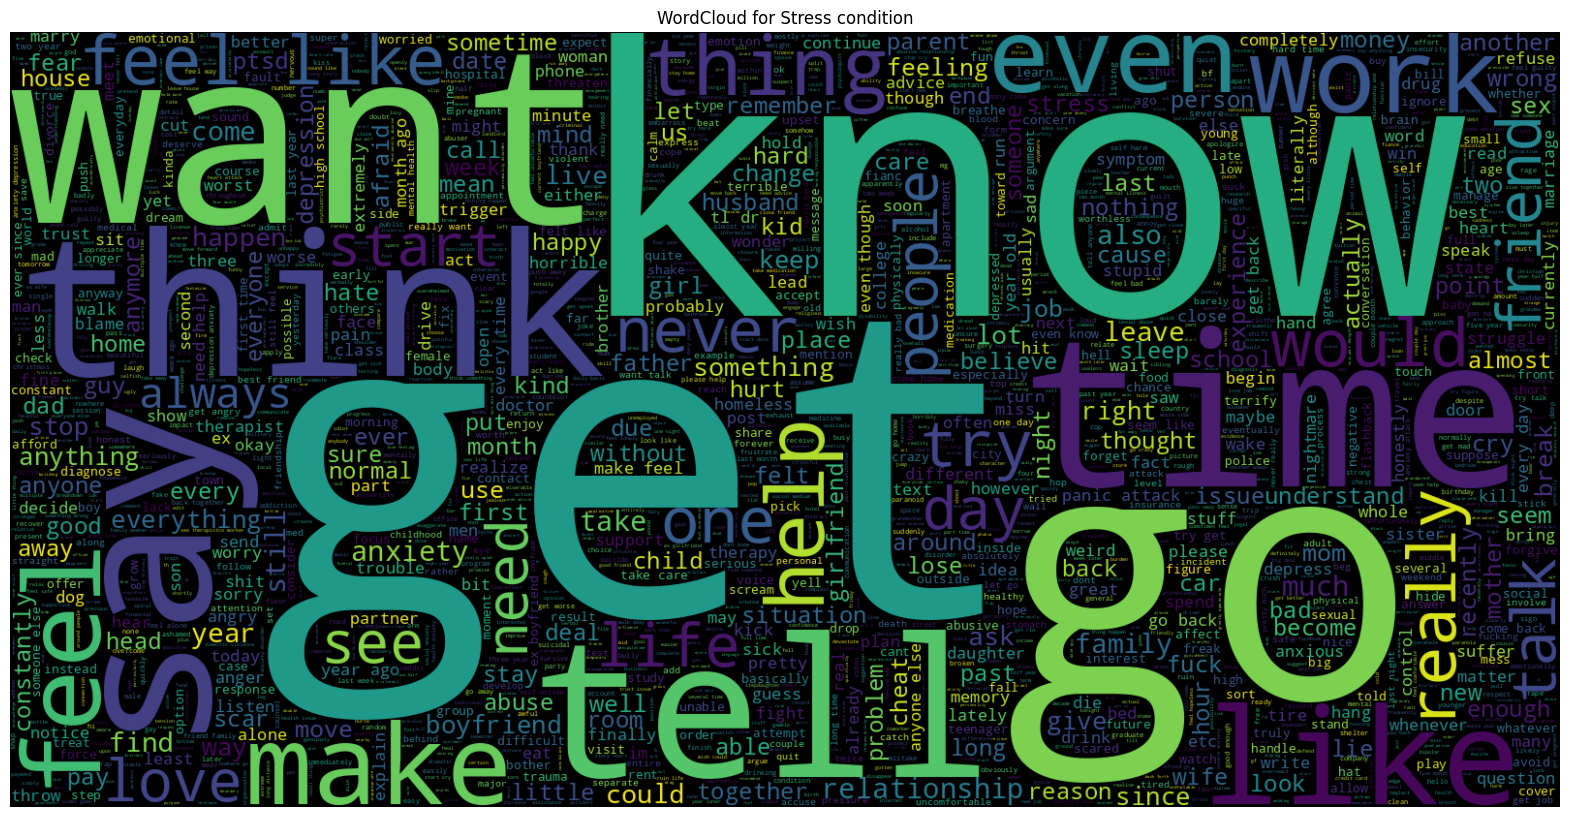

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
plt.title('WordCloud for Stress condition')
plt.axis('off')

wc = WordCloud(max_words=2000 , width=1600 , height=800, stopwords=stop_words).generate(" ".join(df[df.label == 1].processed_text))
plt.imshow(wc, interpolation = 'bilinear')

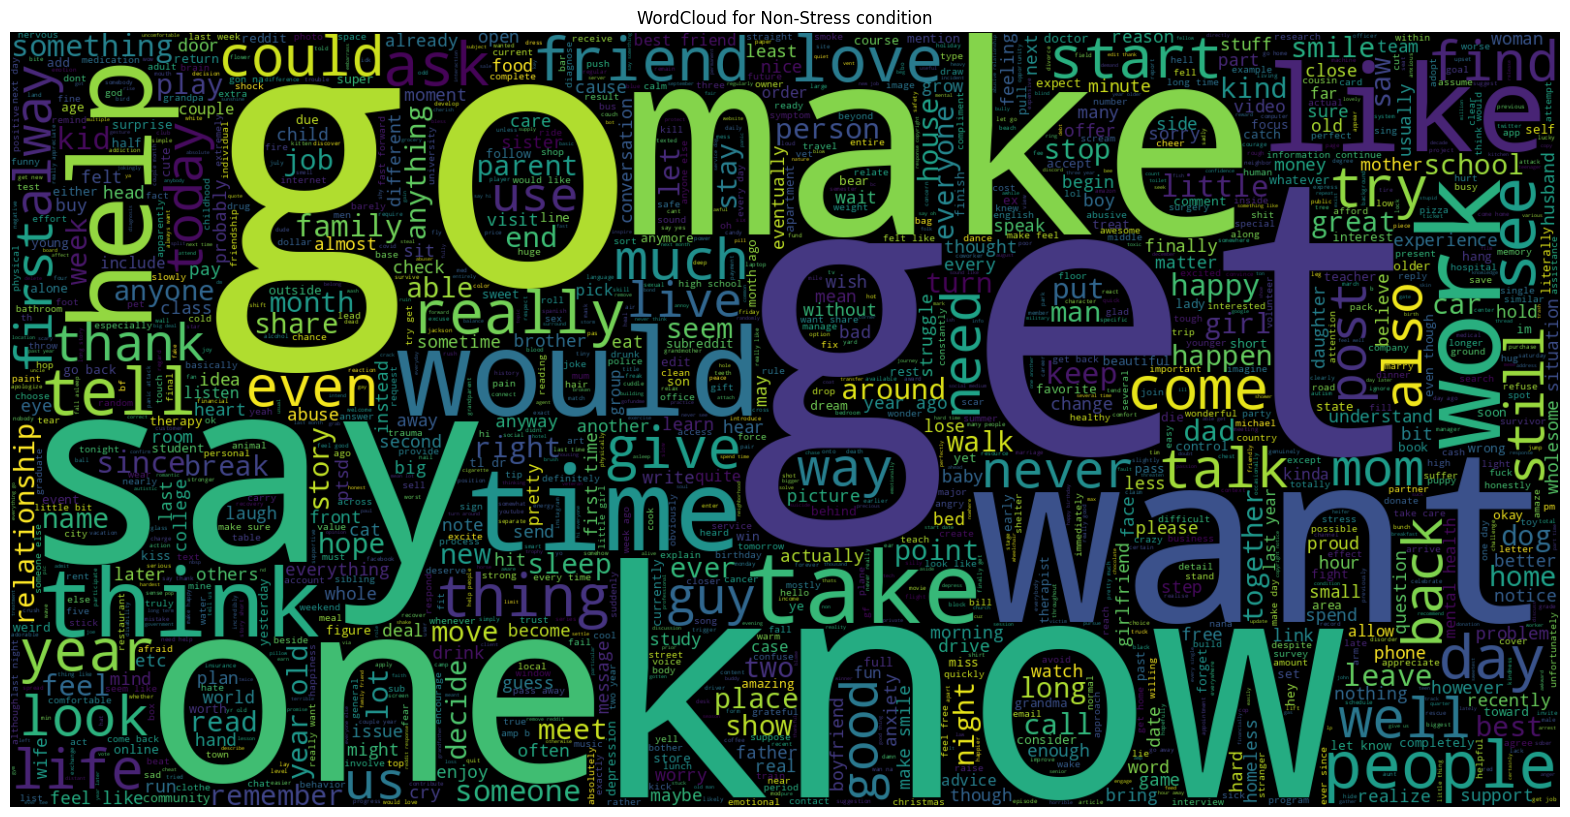

In [26]:
plt.figure(figsize = (20,20)) 
plt.title('WordCloud for Non-Stress condition')
plt.axis('off')

wc = WordCloud(max_words=2000 , width=1600 , height=800, stopwords=stop_words).generate(" ".join(df[df.label == 0].processed_text))
plt.imshow(wc, interpolation = 'bilinear')